# MCTS along priority JIT acceleration

In [2]:
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import time
import re
from collections import defaultdict
import pprint
import math
from typing import Tuple, List, Set, Callable, NamedTuple, Union, Optional, Iterable, Dict
from multiprocessing import Pool
from sympy import Rational, Integer
from sympy.core.numbers import igcd
from tqdm.notebook import trange

import psutil
import os

## Priority

In [3]:
def count_idle_cpus(threshold: float = 10.0) -> int:
    """
    Count CPU cores with usage below the threshold.

    Args:
        threshold (float): Utilization percentage below which a core is considered idle.

    Returns:
        int: Number of idle CPU cores.
    """
    usage: List[float] = psutil.cpu_percent(percpu=True)
    # return sum(1 for u in usage if u < threshold)
    return 1

In [4]:
CPU_CORES = 4

In [5]:
def binomial(n, k):
    if hasattr(math, "comb"):
        return math.comb(n, k)
    # Fallback for Python <3.8
    if 0 <= k <= n:
        num = 1
        denom = 1
        for i in range(1, k+1):
            num *= n - (i - 1)
            denom *= i
        return num // denom
    return 0

class QQ:
    def __init__(self, numerator, denominator=1):
        if denominator == 0:
            raise ZeroDivisionError("Denominator cannot be zero.")
        if not isinstance(numerator, int):
            numerator = Integer(numerator)
        if not isinstance(denominator, int):
            denominator = Integer(denominator)
        g = igcd(numerator, denominator)
        self.num = Integer(numerator // g)
        self.den = Integer(denominator // g)
        if self.den < 0:
            self.num = -self.num
            self.den = -self.den

    def __add__(self, other):
        if not isinstance(other, QQ):
            other = QQ(other)
        num = self.num * other.den + other.num * self.den
        den = self.den * other.den
        return QQ(num, den)

    def __sub__(self, other):
        if not isinstance(other, QQ):
            other = QQ(other)
        num = self.num * other.den - other.num * self.den
        den = self.den * other.den
        return QQ(num, den)

    def __mul__(self, other):
        if not isinstance(other, QQ):
            other = QQ(other)
        return QQ(self.num * other.num, self.den * other.den)

    def __truediv__(self, other):
        if not isinstance(other, QQ):
            other = QQ(other)
        if other.num == 0:
            raise ZeroDivisionError("Division by zero.")
        return QQ(self.num * other.den, self.den * other.num)

    def __neg__(self):
        return QQ(-self.num, self.den)

    def __eq__(self, other):
        if isinstance(other, str):
            return False
        if not isinstance(other, QQ):
            other = QQ(other)
        return self.num == other.num and self.den == other.den

    def __float__(self):
        return float(self.num) / float(self.den)

    def __repr__(self):
        return f"{self.num}/{self.den}" if self.den != 1 else f"{self.num}"
    
    def __hash__(self):
        return hash((self.num, self.den))

    def to_sympy(self):
        return Rational(self.num, self.den)

class Point(NamedTuple):
    """An integer point in 2D space."""
    x: int
    y: int

class Line:
    """
    Represents a line defined by a rational slope and a point on the line.

    Attributes:
        slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
        point (Point): An arbitrary point on the line.
    """

    def __init__(self, slope: Union[QQ, str], point: Point):
        """
        Initialize a line with a given slope and a point on the line.

        Args:
            slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
            point (Point): A point on the line.
        """
        self.slope = slope
        self.point = point

    @classmethod
    def from_points(cls, p1: Point, p2: Point) -> 'Line':
        """
        Construct a line from two points.

        The slope is computed from the two points. The stored point is p1 without any minimization.

        Args:
            p1 (Point): First point.
            p2 (Point): Second point.

        Returns:
            Line: Line through p1 and p2 with p1 stored as the point.
        """
        dx = p2.x - p1.x
        dy = p2.y - p1.y
        if dx == 0:
            slope = 'inf'
        else:
            slope = QQ(dy) / QQ(dx)
        return cls(slope, p1)

    @classmethod
    def from_point_slope_of_line(cls, p: Point, slope: Union[QQ, str]) -> 'Line':
        """
        Construct a line from a point and a slope.

        Args:
            p (Point): A point on the line.
            slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.

        Returns:
            Line: Line defined by the point and slope.
        """
        return cls(slope, p)


def slope_of_line(p1: Point, p2: Point) -> Union[QQ, str]:
    """
    Calculate the slope of the line segment connecting two points.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).

    Returns:
        Union[QQ, str]: The slope as a rational number (QQ) if defined, otherwise the string 'inf' if the line is vertical.
    """
    x1, y1 = p1
    x2, y2 = p2
    dx = x2 - x1
    dy = y2 - y1
    if dx == 0:
        return 'inf'
    return QQ(dy) / QQ(dx)

def are_collinear(p1: Point, p2: Point, p3: Point) -> bool:
    """
    Determine if three points are collinear.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).
        p3 (Point): The third point as a named tuple with integer coordinates (x, y).

    Returns:
        bool: True if the three points are collinear, False otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

def plot_no_three_in_line(points: Iterable[Point], n: Optional[int] = None, title: str = "No-3-in-line Set") -> None:
    """
    Plot a set of points on an n x n grid, illustrating a no-3-in-line configuration.

    Args:
        points (Iterable[Point]): Iterable of points to plot.
        n (Optional[int]): Size of the grid. If None, computed from the points.
        title (str): Title of the plot.

    Returns:
        None
    """
    points = list(points)
    if not points:
        print("No points to plot.")
        return

    xs, ys = zip(*points)
    if n is None:
        n = max(max(xs), max(ys)) + 1

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=100, c='blue', edgecolors='black')
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-1, n)
    plt.ylim(-1, n)
    plt.show()

def find_missing_data(data: Dict[str, Iterable[Tuple[Union[int, str], Union[int, str]]]]) -> Dict[str, Iterable[Tuple[int, Union[int, str]]]]:
    """
    Identify entries with missing data labeled as 'NO DATA' in intervals.

    Args:
        data (Dict[str, Iterable[Tuple[Union[int, str], Union[int, str]]]]): Dictionary mapping keys to iterables of (start, end) intervals.

    Returns:
        Dict[str, Iterable[Tuple[int, Union[int, str]]]]: Dictionary mapping keys to iterables of tuples containing the index of the interval and the start value where 'NO DATA' occurs.
    """
    missing = {}
    for key, intervals in data.items():
        missing_entries = []
        for i, (start, end) in enumerate(intervals):
            if end == 'NO DATA':
                missing_entries.append((i, start))
        if missing_entries:
            missing[key] = missing_entries
    return missing

def points_on_line_pp(p1: Point, p2: Point, grid_size: int) -> Set[Point]:
    """
    Generate points with integer coordinates on the line segment between two points,
    assuming the segment lies on a line with rational slope and intercept.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).

    Returns:
        Set[Point]: Set of points on the line segment from p1 to p2.
    """
    s = slope_of_line(p1, p2)
    if s == 'inf':
        x = p1.x
        return {Point(x, y) for y in range(grid_size) if 0 <= x < grid_size}
    a = s
    b = QQ(p1.y) - a * QQ(p1.x)
    return {Point(x, int(y)) for x in range(grid_size)
            if (y := a * QQ(x) + b).denominator() == 1 and 0 <= y < grid_size}

def points_on_line_l(line: Line, grid_size: int) -> Set[Point]:
    """
    Generate points with integer coordinates on the line defined by the given line object.

    Args:
        line (Line): The line object representing the line.
        grid_size (int): The size of the grid.

    Returns:
        Set[Point]: Set of points on the line within the grid size.
    """
    a = line.slope
    p = line.point
    if a == 'inf':
        x = p.x
        return {Point(x, y) for y in range(grid_size) if 0 <= x < grid_size}
    b = QQ(p.y) - a * QQ(p.x)
    return {Point(x, int(y)) for x in range(grid_size)
            if (y := a * QQ(x) + b).denominator() == 1 and 0 <= y < grid_size}

In [6]:
# 在 QQ 类中修改 __eq__ 方法
def __eq__(self, other):
    if isinstance(other, str):
        return False
    if not isinstance(other, QQ):
        other = QQ(other)
    return self.num == other.num and self.den == other.den

In [7]:
def count_points_on_line(p: Point, slope: Union[QQ, str], grid_size: int) -> int:
    """
    Count the number of integer points (excluding point p) on line defined by an intersection point and slope.

    Args:
        p (Point): The given point the line passes through.
        slope (Union[QQ, str): The slope of the line (non-negative), either as a rational number (QQ) or 'inf' for vertical lines.
        grid_size (int): The size of the grid.

    Returns:
        int: The number of integer points on the line.
    """
    if min(p.x, p.y) < 0 or max(p.x, p.y) >= grid_size:
        return 0
    if slope == 'inf' or slope == 0:
        return grid_size - 1

    dy = abs(slope.num)
    dx = abs(slope.den)
    U = math.floor((grid_size - p.x - 1) / dx)
    R = math.floor((grid_size - p.y - 1) / dy)

    D = math.floor(p.x / dx)
    L = math.floor(p.y / dy)
    N_positive = min(U, R) + min(D, L) 
    N_negative = min(U, L) + min(D, R)

    if (N_positive if slope.num > 0 else N_negative) < 0:
        print(f"point: {p}, slope: {slope}")
        print(f"U: {U}, R: {R}, D: {D}, L: {L}, N_positive: {N_positive}, N_negative: {N_negative}")
    return N_positive if slope.num > 0 else N_negative

In [8]:
def _slopes_for_dx_chunk(dx_chunk: List[int], grid_size: int) -> List[QQ]:
    """
    Compute unique slopes for a chunk of dx values within the grid.

    Args:
        dx_chunk (List[int]): A sublist of dx integers to process.
        grid_size (int): The size of the grid.

    Returns:
        List[QQ]: List of unique rational slopes generated from dy/dx pairs in the chunk.
    """
    local_seen = set()
    local_slopes = []
    for dx in dx_chunk:
        for dy in range(1, grid_size):
            s = QQ(dy) / QQ(dx)
            if s not in local_seen:
                local_slopes.append(s)
                local_seen.add(s)
    return local_slopes

def get_possible_slopes(grid_size: int, idle_cores: int = 0) -> Set[Union[QQ, str]]:
    """
    Generate all possible slopes for lines on a grid of given size.

    Args:
        grid_size (int): The size of the grid.
        idle_cores (int): Number of cores to use for parallelism. If <= 1, runs serially.

    Returns:
        Set[Union[QQ, str]]: Set of unique slopes (rational numbers and 'inf' for vertical lines).
    """
    dx_values = list(range(1, grid_size))

    if idle_cores > 1:
        chunk_size = (len(dx_values) + idle_cores - 1) // idle_cores
        chunks = [dx_values[i:i + chunk_size] for i in range(0, len(dx_values), chunk_size)]
        with Pool(idle_cores) as pool:
            results = pool.starmap(_slopes_for_dx_chunk, [(chunk, grid_size) for chunk in chunks])
    else:
        results = [_slopes_for_dx_chunk(dx_values, grid_size)]

    slopes = {QQ(0)}
    for sublist in results:
        for s in sublist:
            slopes.add(s)
            slopes.add(-s)
    slopes.add('inf')
    return slopes


def point_collinear_count(p1: Point, grid_size: int) -> int:
    """
    Count the number of collinear triples on that line including that point (not including horizontal and vertical line).

    Args:
        p1 (Point): The point to check.
        grid_size (int): The size of the grid.

    Returns:
        int: Sum over slopes of binomial(count, 2) for points collinear with p1.
    """
    idle = count_idle_cpus()
    slopes = get_possible_slopes(grid_size, idle_cores=idle)
    counts = sum([
        binomial(count_points_on_line(p1, slope, grid_size), 2)
        for slope in slopes if slope != 0 and slope != 'inf'
    ])
    return counts

# NOISE = random.uniform(-0.1, 0.1) 
NOISE =  0

def collinear_count_priority(n):
    def priority(point):
        return -point_collinear_count(point, n) + NOISE
    return priority

def priority_grid(n):
    """
    Return a 2D numpy array of priority values for each point in an n x n grid.

    Args:
        n (int): The grid size.

    Returns:
        np.ndarray: 2D array of priority values.
    """
    priority_fn = collinear_count_priority(n)
    arr = np.zeros((n, n))
    for x in trange(n):
        for y in range(n):
            arr[x, y] = priority_fn(Point(x, y))
    return arr

# Example usage:
# grid = priority_grid(3)
# print(grid)

def heatmap(grid_values: np.ndarray, title: str = "") -> None:
    """
    Plot a heatmap from a 2D numpy array of values and save it to a file named heatmap{n}.png.
    
    Args:
        grid_values (np.ndarray): 2D array of values to plot.
        title (str): Title of the heatmap plot.
    """
    import matplotlib.pyplot as plt

    n = grid_values.shape[0]
    plt.figure(figsize=(6,6))
    plt.imshow(grid_values, origin='lower', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Priority')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.show()

In [9]:
def compute_and_save_priority_grids(priority_grid_fn, size_list=None, output_dir='priority_grids'):
    """
    Compute priority grids for each n in size_list (if not already saved),
    and save them as .npy files in the output_dir directory.

    Parameters:
    - priority_grid_fn: A function to generate the priority grid, which takes n as input.
    - size_list: List of n values to compute.
    - output_dir: Directory where .npy files will be saved.
    """
    # Make sure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for n in size_list:
        # Check if the file already exists
        filename = os.path.join(output_dir, f'priority_grid_{n}.npy')
        if os.path.exists(filename):
            print(f"priority_grid_{n}.npy already exists. Skipping computation.")
            continue  # Skip this n if the file exists

        # Compute the priority grid for the current n
        grid = priority_grid_fn(n)
        
        # Save the grid as a .npy file
        np.save(filename, grid)
        print(f"Saved priority_grid_{n}.npy")


def load_priority_grid(n, input_dir='priority_grids'):
    """
    Load the priority grid numpy array for a given n.

    Parameters:
    - n: The n value of the grid to load.
    - input_dir: Directory containing the .npy files.

    Returns:
    - priority_grid (np.ndarray): The loaded priority grid.
    """
    filename = os.path.join(input_dir, f'priority_grid_{n}.npy')
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File {filename} not found.")
    grid = np.load(filename)
    return grid

n_list = np.arange(10,15,1)
compute_and_save_priority_grids(priority_grid, size_list=n_list)

priority_grid_10.npy already exists. Skipping computation.


  0%|          | 0/11 [00:00<?, ?it/s]

Saved priority_grid_11.npy


  0%|          | 0/12 [00:00<?, ?it/s]

Saved priority_grid_12.npy


  0%|          | 0/13 [00:00<?, ?it/s]

Saved priority_grid_13.npy


  0%|          | 0/14 [00:00<?, ?it/s]

Saved priority_grid_14.npy


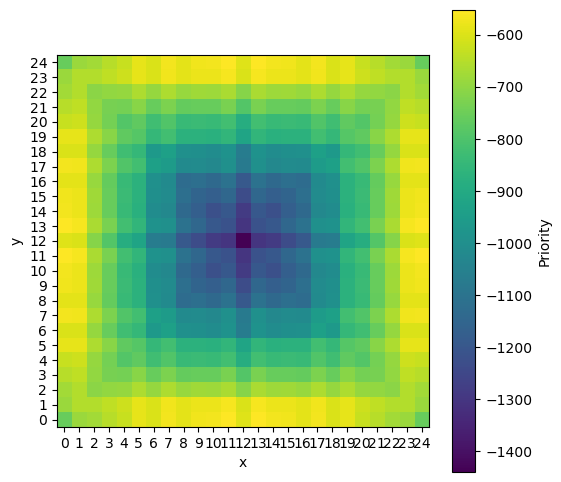

In [10]:
heatmap(load_priority_grid(25))

In [13]:
priority_grid(5)

  0%|          | 0/5 [00:00<?, ?it/s]

array([[ -8.,  -4.,  -4.,  -4.,  -8.],
       [ -4.,  -7.,  -8.,  -7.,  -4.],
       [ -4.,  -8., -16.,  -8.,  -4.],
       [ -4.,  -7.,  -8.,  -7.,  -4.],
       [ -8.,  -4.,  -4.,  -4.,  -8.]])